# PEFT Methods under Differential Privacy — Final Results

**Model:** BERT-tiny (`prajjwal1/bert-tiny`)  
**Tasks:** SST-2, QNLI, QQP, MNLI (GLUE benchmark)  
**Privacy settings:** ε = 8 (DP-SGD) and ε = ∞ (non-private)  
**Methods:** Full Fine-Tuning, Last-Layer FT, LoRA, IA³, Soft Prompt, Prefix Tuning, Soft Prompt + LoRA, Prefix + LoRA

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

os.makedirs("plots", exist_ok=True)

mpl.rcParams.update({
    "font.family":        "DejaVu Sans",
    "font.size":          11,
    "axes.titlesize":     13,
    "axes.labelsize":     11,
    "xtick.labelsize":    9.5,
    "ytick.labelsize":    9.5,
    "legend.fontsize":    9,
    "legend.framealpha":  0.9,
    "figure.dpi":         150,
    "savefig.dpi":        300,
    "savefig.bbox":       "tight",
    "axes.spines.top":    False,
    "axes.spines.right":  False,
    "axes.grid":          True,
    "grid.linestyle":     "--",
    "grid.alpha":         0.35,
    "grid.color":         "#cccccc",
})

C_PRIV  = "#D6604D"
C_NPRIV = "#2166AC"

METHOD_MARKERS = ["o", "s", "^", "D", "v", "P", "*", "X"]

METHOD_ORDER = [
    "full-finetuning",
    "last-layer-finetuning",
    "lora",
    "ia3",
    "soft-prompt",
    "prefix",
    "soft-prompt+lora",
    "prefix+lora",
]
METHOD_LABELS = {
    "full-finetuning":       "Full FT",
    "last-layer-finetuning": "Last-Layer FT",
    "lora":                  "LoRA",
    "ia3":                   "IA³",
    "soft-prompt":           "Soft Prompt",
    "prefix":                "Prefix Tuning",
    "soft-prompt+lora":      "Soft Prompt + LoRA",
    "prefix+lora":           "Prefix + LoRA",
}
DATASET_LABELS = {"sst2": "SST-2", "qnli": "QNLI", "qqp": "QQP", "mnli": "MNLI"}
DATASET_ORDER  = ["sst2", "qnli", "qqp", "mnli"]

df = pd.read_csv("final_aggregated_results.csv")
df["MethodLabel"]  = df["Method"].map(METHOD_LABELS)
df["DatasetLabel"] = df["Dataset"].map(DATASET_LABELS)
df["PrivacyLabel"] = df["Privacy(Epsilon)"].map({-1: "ε = ∞", 8: "ε = 8"})
df_np = df[df["Privacy(Epsilon)"] == -1]
df_dp = df[df["Privacy(Epsilon)"] ==  8]

print(f"Loaded {len(df)} rows | Methods: {df.Method.nunique()} | Datasets: {df.Dataset.nunique()}")


Loaded 64 rows | Methods: 8 | Datasets: 4


## Figure 1 — Accuracy Comparison Across Methods and Datasets

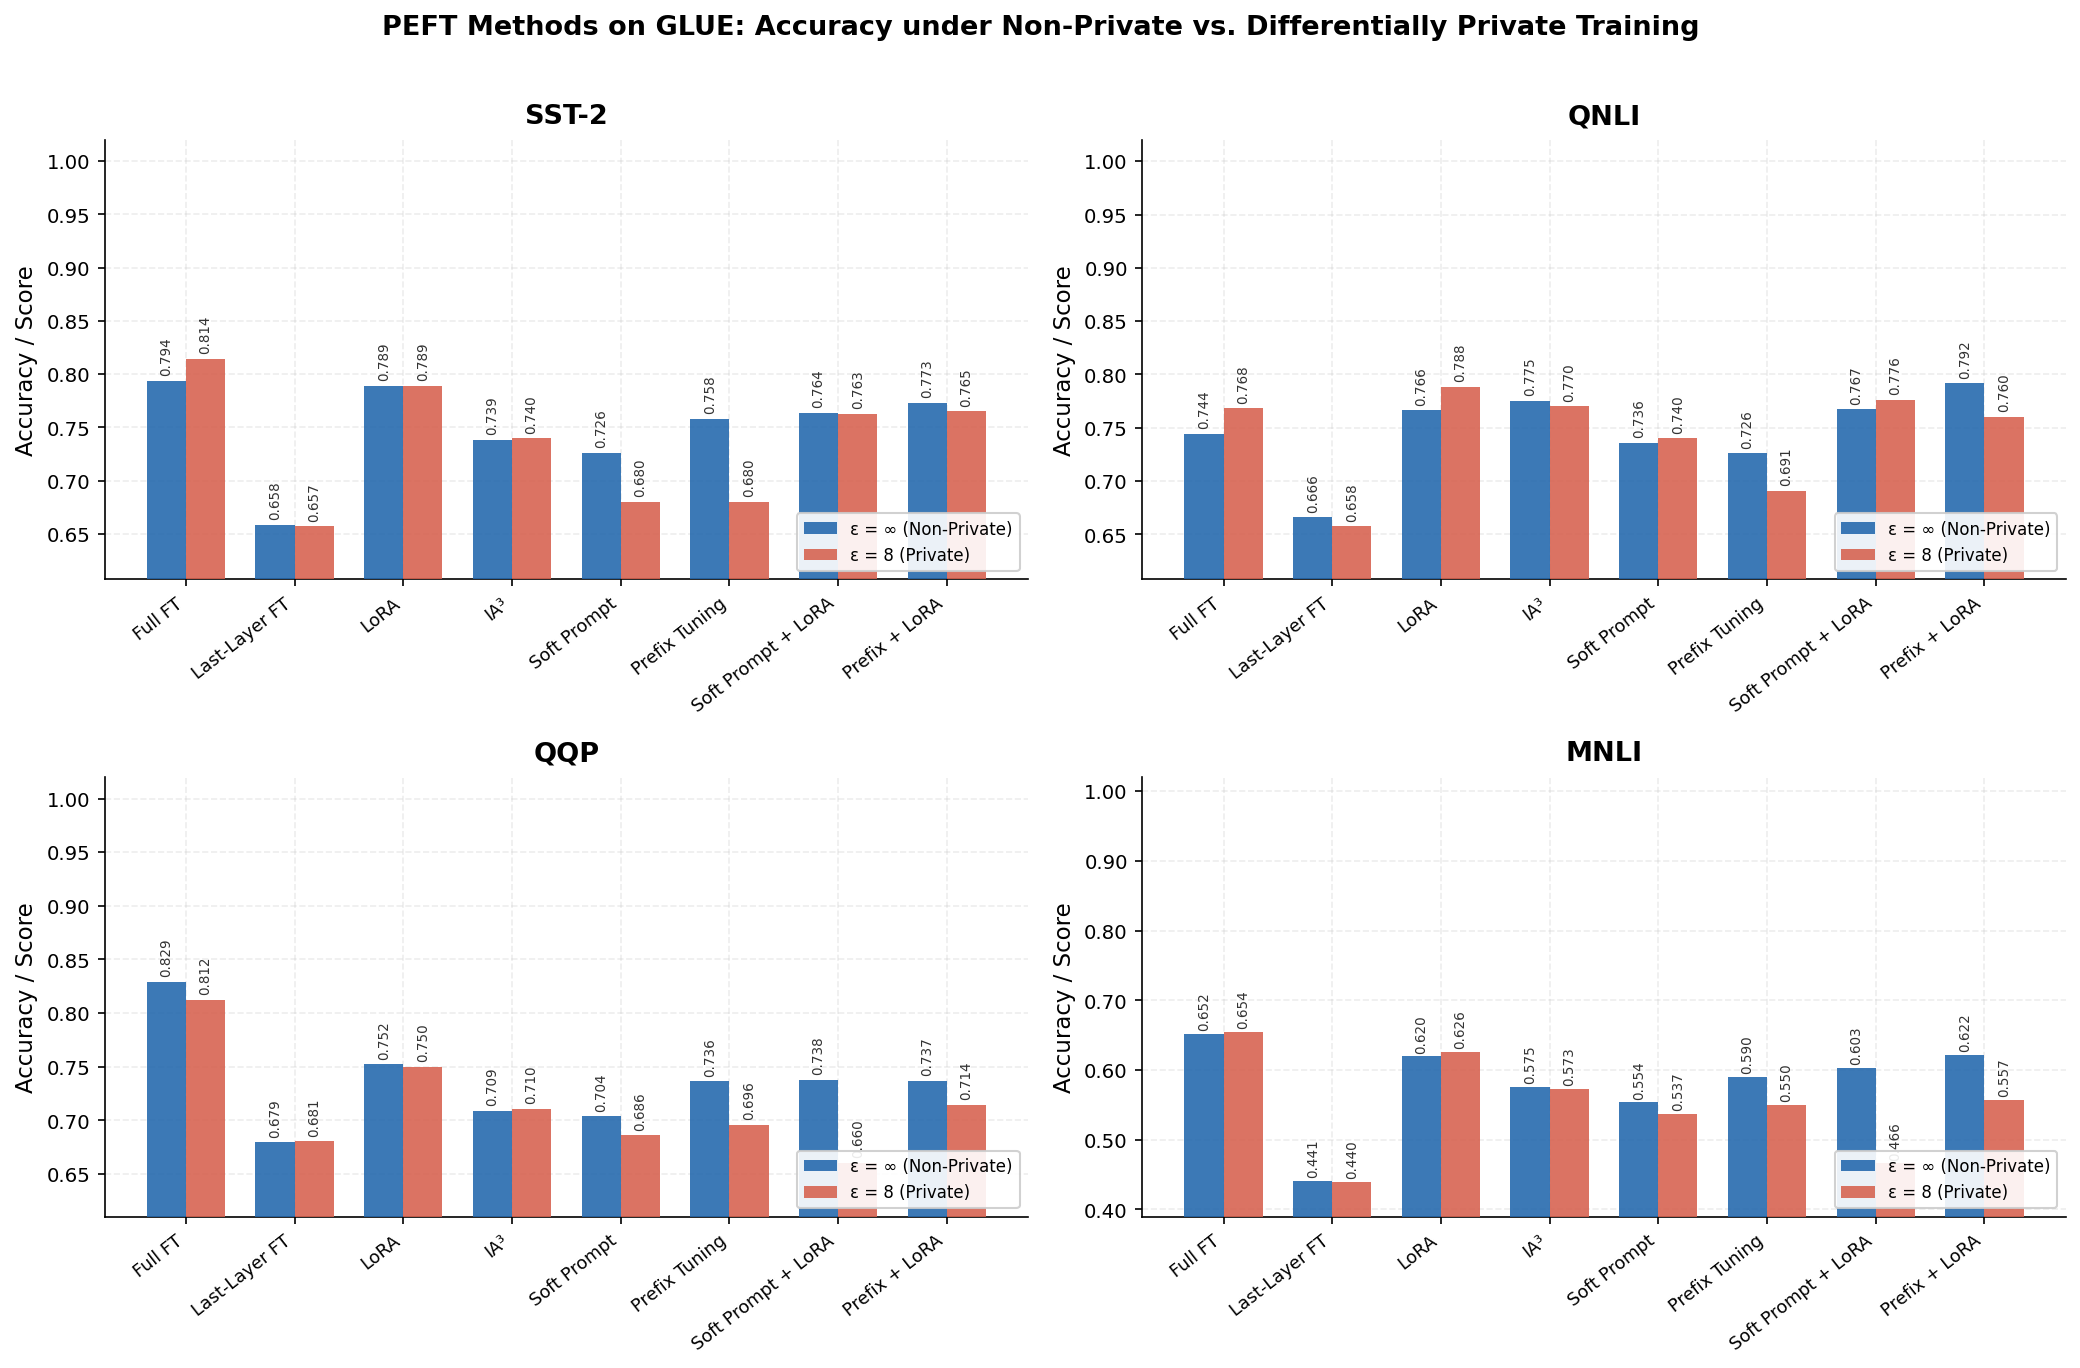

Saved → plots/fig1_accuracy_by_dataset.png / .pdf


In [2]:
fig, axes = plt.subplots(2, 2, figsize=(14, 9), sharey=False)
axes = axes.flatten()

x      = np.arange(len(METHOD_ORDER))
width  = 0.36
xlabels = [METHOD_LABELS[m] for m in METHOD_ORDER]

for ax, dataset in zip(axes, DATASET_ORDER):
    scores_np = (
        df_np[df_np["Dataset"] == dataset]
        .set_index("Method")["Score"].reindex(METHOD_ORDER).values
    )
    scores_dp = (
        df_dp[df_dp["Dataset"] == dataset]
        .set_index("Method")["Score"].reindex(METHOD_ORDER).values
    )

    b1 = ax.bar(x - width/2, scores_np, width, color=C_NPRIV, alpha=0.88,
                label="ε = ∞ (Non-Private)", zorder=3)
    b2 = ax.bar(x + width/2, scores_dp, width, color=C_PRIV,  alpha=0.88,
                label="ε = 8 (Private)",     zorder=3)

    # Value annotations on each bar
    for bar in list(b1) + list(b2):
        h = bar.get_height()
        if not np.isnan(h):
            ax.text(
                bar.get_x() + bar.get_width() / 2, h + 0.005,
                f"{h:.3f}", ha="center", va="bottom", fontsize=6.5, rotation=90,
                color="#333333"
            )

    ax.set_title(DATASET_LABELS[dataset], fontweight="bold", pad=8)
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, rotation=38, ha="right", fontsize=8.5)
    ax.set_ylabel("Accuracy / Score")
    ymin = max(0, min(np.nanmin(scores_np), np.nanmin(scores_dp)) - 0.05)
    ax.set_ylim(ymin, 1.02)
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))
    ax.legend(loc="lower right", fontsize=8)

fig.suptitle(
    "PEFT Methods on GLUE: Accuracy under Non-Private vs. Differentially Private Training",
    fontsize=13, fontweight="bold", y=1.01
)
plt.tight_layout()
plt.savefig("plots/fig1_accuracy_by_dataset.png")
plt.savefig("plots/fig1_accuracy_by_dataset.pdf")
plt.show()
print("Saved → plots/fig1_accuracy_by_dataset.png / .pdf")

## Figure 2 — Average Accuracy Across All Datasets

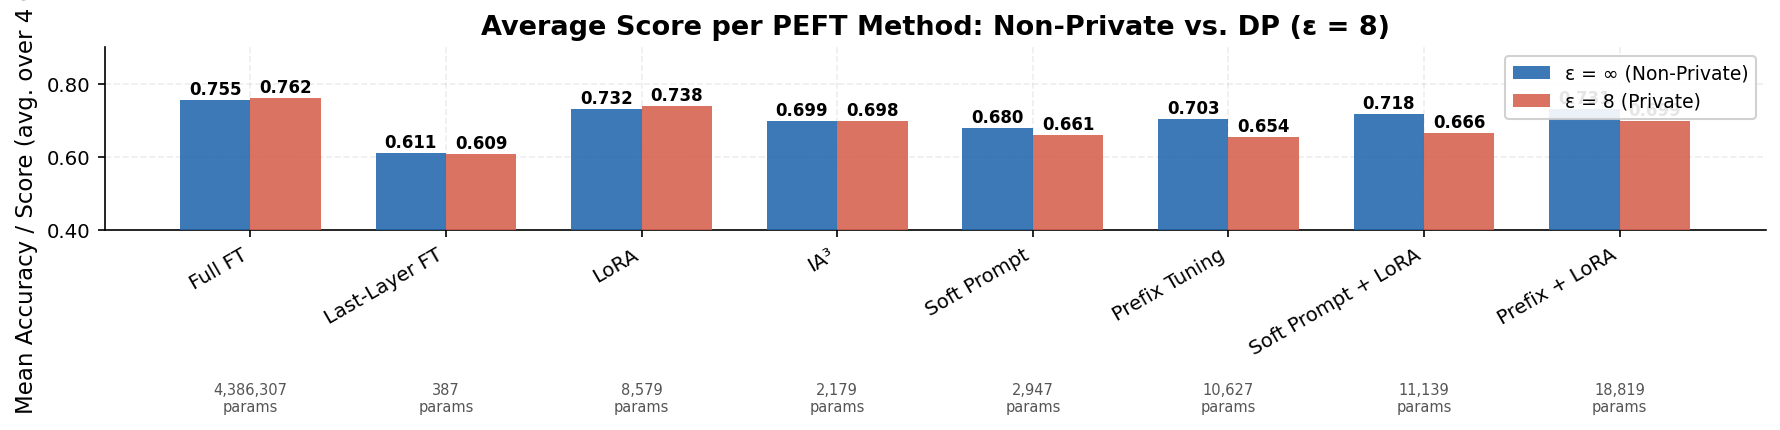

Saved → plots/fig2_average_accuracy.png / .pdf


In [3]:
avg_np = df_np.groupby("Method")["Score"].mean().reindex(METHOD_ORDER)
avg_dp = df_dp.groupby("Method")["Score"].mean().reindex(METHOD_ORDER)
params = df_np.groupby("Method")["NumParams"].first().reindex(METHOD_ORDER)

xlabels = [METHOD_LABELS[m] for m in METHOD_ORDER]
x = np.arange(len(METHOD_ORDER))
width = 0.36

fig, ax = plt.subplots(figsize=(12, 5.5))

b1 = ax.bar(x - width/2, avg_np, width, color=C_NPRIV, alpha=0.88,
            label="ε = ∞ (Non-Private)", zorder=3)
b2 = ax.bar(x + width/2, avg_dp, width, color=C_PRIV,  alpha=0.88,
            label="ε = 8 (Private)",     zorder=3)

# Annotate with both score and param count
for i, (bar_np, bar_dp, p) in enumerate(zip(b1, b2, params)):
    for bar, score in [(bar_np, avg_np.iloc[i]), (bar_dp, avg_dp.iloc[i])]:
        ax.text(
            bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.004,
            f"{score:.3f}", ha="center", va="bottom", fontsize=8, fontweight="bold"
        )
    # Param count below x-axis
    ax.text(
        x[i], ax.get_ylim()[0] - 0.015,
        f"{int(p):,}\nparams", ha="center", va="top", fontsize=7, color="#555555"
    )

ax.set_xticks(x)
ax.set_xticklabels(xlabels, rotation=30, ha="right")
ax.set_ylabel("Mean Accuracy / Score (avg. over 4 GLUE tasks)")
ax.set_title(
    "Average Score per PEFT Method: Non-Private vs. DP (ε = 8)",
    fontweight="bold"
)
ax.set_ylim(0.4, 0.9)
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))
ax.legend(loc="upper right")
plt.tight_layout()
plt.savefig("plots/fig2_average_accuracy.png")
plt.savefig("plots/fig2_average_accuracy.pdf")
plt.show()
print("Saved → plots/fig2_average_accuracy.png / .pdf")

## Figure 4 — Privacy Cost Heatmap (Accuracy Drop: ε=∞ → ε=8)

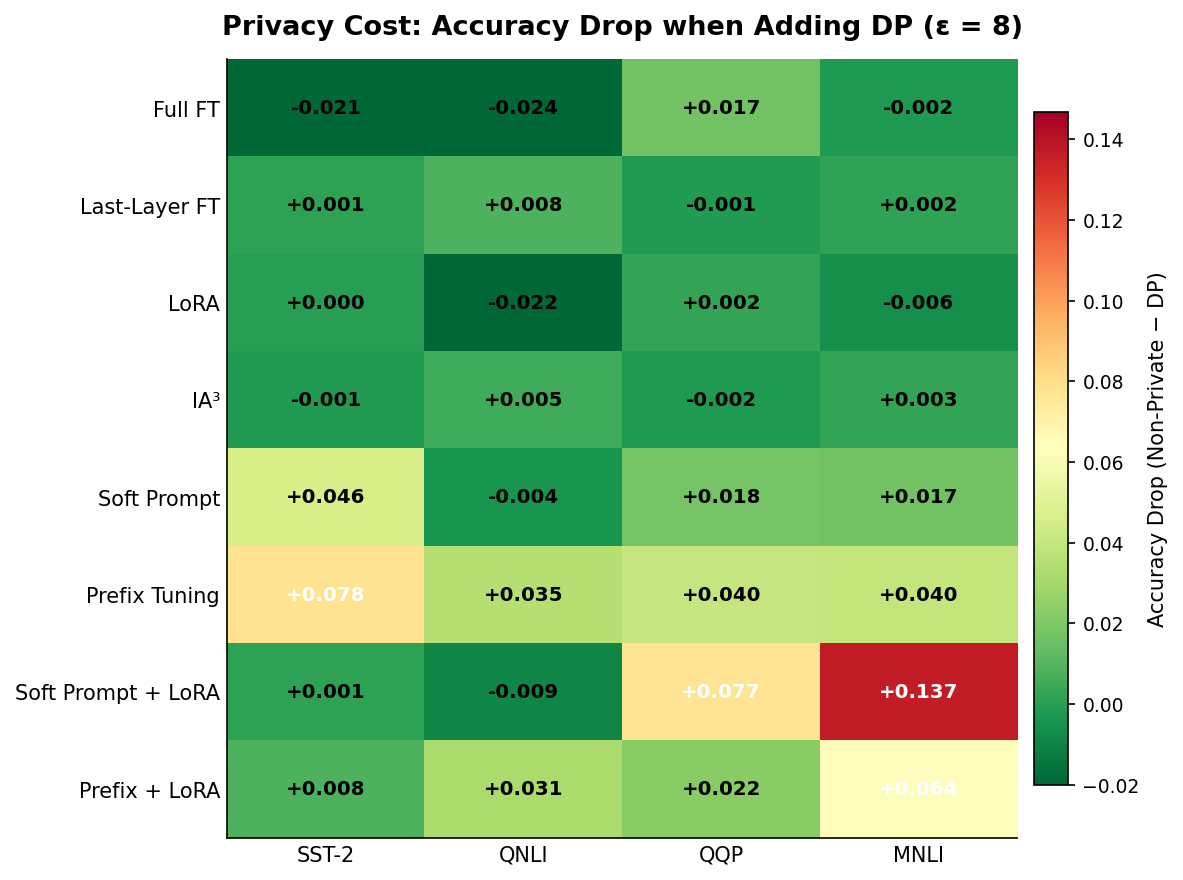

Saved → plots/fig4_privacy_cost_heatmap.png / .pdf


In [4]:
pivot_np = df_np.pivot(index="Method", columns="Dataset", values="Score").reindex(
    index=METHOD_ORDER, columns=DATASET_ORDER
)
pivot_dp = df_dp.pivot(index="Method", columns="Dataset", values="Score").reindex(
    index=METHOD_ORDER, columns=DATASET_ORDER
)
pivot_drop = (pivot_np - pivot_dp)

fig, ax = plt.subplots(figsize=(8, 6))

vmax = pivot_drop.values.max()
vmin = pivot_drop.values.min()
im = ax.imshow(
    pivot_drop.values, cmap="RdYlGn_r",
    aspect="auto", vmin=max(vmin - 0.01, -0.02), vmax=vmax + 0.01
)

cbar = plt.colorbar(im, ax=ax, pad=0.02, fraction=0.04)
cbar.set_label("Accuracy Drop (Non-Private − DP)", fontsize=10)
cbar.ax.tick_params(labelsize=9)

ax.set_xticks(range(len(DATASET_ORDER)))
ax.set_xticklabels([DATASET_LABELS[d] for d in DATASET_ORDER], fontsize=10)
ax.set_yticks(range(len(METHOD_ORDER)))
ax.set_yticklabels([METHOD_LABELS[m] for m in METHOD_ORDER], fontsize=10)

# Annotate each cell
for i in range(len(METHOD_ORDER)):
    for j in range(len(DATASET_ORDER)):
        val = pivot_drop.values[i, j]
        color = "white" if abs(val) > 0.06 else "black"
        ax.text(
            j, i, f"{val:+.3f}",
            ha="center", va="center", fontsize=9.5,
            fontweight="bold", color=color
        )

ax.set_title(
    "Privacy Cost: Accuracy Drop when Adding DP (ε = 8)",
    fontweight="bold", pad=12
)
ax.tick_params(axis="both", which="both", length=0)
ax.grid(False)

plt.tight_layout()
plt.savefig("plots/fig4_privacy_cost_heatmap.png")
plt.savefig("plots/fig4_privacy_cost_heatmap.pdf")
plt.show()
print("Saved → plots/fig4_privacy_cost_heatmap.png / .pdf")

## Figure 5 — Summary Results Table

In [5]:
def make_table(eps_val, eps_label):
    sub = df[df["Privacy(Epsilon)"] == eps_val]
    pivot = sub.pivot(index="Method", columns="Dataset", values="Score").reindex(
        index=METHOD_ORDER, columns=DATASET_ORDER
    )
    params = sub.groupby("Method")["NumParams"].first().reindex(METHOD_ORDER)
    avg    = pivot.mean(axis=1)
    pivot.insert(0, "# Params", params)
    pivot["Avg."] = avg
    pivot.index = [METHOD_LABELS[m] for m in METHOD_ORDER]
    pivot.columns = ["# Params"] + [DATASET_LABELS[d] for d in DATASET_ORDER] + ["Avg."]
    return pivot

for eps_val, eps_label in [(-1, "ε = ∞  (Non-Private)"), (8, "ε = 8  (DP)")]:
    tbl = make_table(eps_val, eps_label)
    score_cols = [DATASET_LABELS[d] for d in DATASET_ORDER] + ["Avg."]
    display(
        tbl.style
        .format({"# Params": "{:,.0f}", **{c: "{:.4f}" for c in score_cols}})
        .highlight_max(
            subset=score_cols, axis=0,
            props="background-color: #c6efce; color: #006100; font-weight: bold;"
        )
        .highlight_min(
            subset=score_cols, axis=0,
            props="background-color: #ffc7ce; color: #9c0006; font-weight: bold;"
        )
        .set_caption(f"<b>{eps_label}</b>")
        .set_table_styles([
            {
                "selector": "caption",
                "props": [("font-size", "14px"), ("text-align", "left"),
                          ("padding", "8px 0"), ("font-weight", "bold")]
            },
            {
                "selector": "th",
                "props": [("background-color", "#f0f0f0"), ("color", "#000000"),
                          ("font-weight", "bold"), ("text-align", "center"),
                          ("padding", "6px 10px"), ("border-bottom", "2px solid #aaa")]
            },
            {
                "selector": "td",
                "props": [("text-align", "center"), ("padding", "5px 10px"),
                          ("color", "#000000")]
            },
        ])
    )
    print()


,# Params,SST-2,QNLI,QQP,MNLI,Avg.
Full FT,"4,386,307",0.7936,0.7443,0.8294,0.6522,0.7549
Last-Layer FT,387,0.6583,0.6661,0.6794,0.4412,0.6112
LoRA,"8,579",0.7890,0.7662,0.7524,0.6196,0.7318
IA³,"2,179",0.7385,0.7752,0.7086,0.5753,0.6994
Soft Prompt,"2,947",0.7259,0.7359,0.7036,0.5535,0.6797
Prefix Tuning,"10,627",0.7580,0.7259,0.7363,0.5901,0.7026
Soft Prompt + LoRA,"11,139",0.7638,0.7672,0.7375,0.6025,0.7177
Prefix + LoRA,"18,819",0.7729,0.7919,0.7367,0.6219,0.7308


,# Params,SST-2,QNLI,QQP,MNLI,Avg.
Full FT,"4,386,307",0.8142,0.7683,0.8124,0.6544,0.7623
Last-Layer FT,387,0.6571,0.6577,0.6806,0.4396,0.6087
LoRA,"8,579",0.7890,0.7882,0.7502,0.6258,0.7383
IA³,"2,179",0.7397,0.7701,0.7104,0.5727,0.6982
Soft Prompt,"2,947",0.6800,0.7399,0.6859,0.5365,0.6606
Prefix Tuning,"10,627",0.6800,0.6908,0.6960,0.5505,0.6543
Soft Prompt + LoRA,"11,139",0.7626,0.7761,0.6602,0.4659,0.6662
Prefix + LoRA,"18,819",0.7649,0.7604,0.7143,0.5574,0.6993


## Figure 6 — DP vs Non-DP: Per-Dataset Score Comparison (Line Plot)

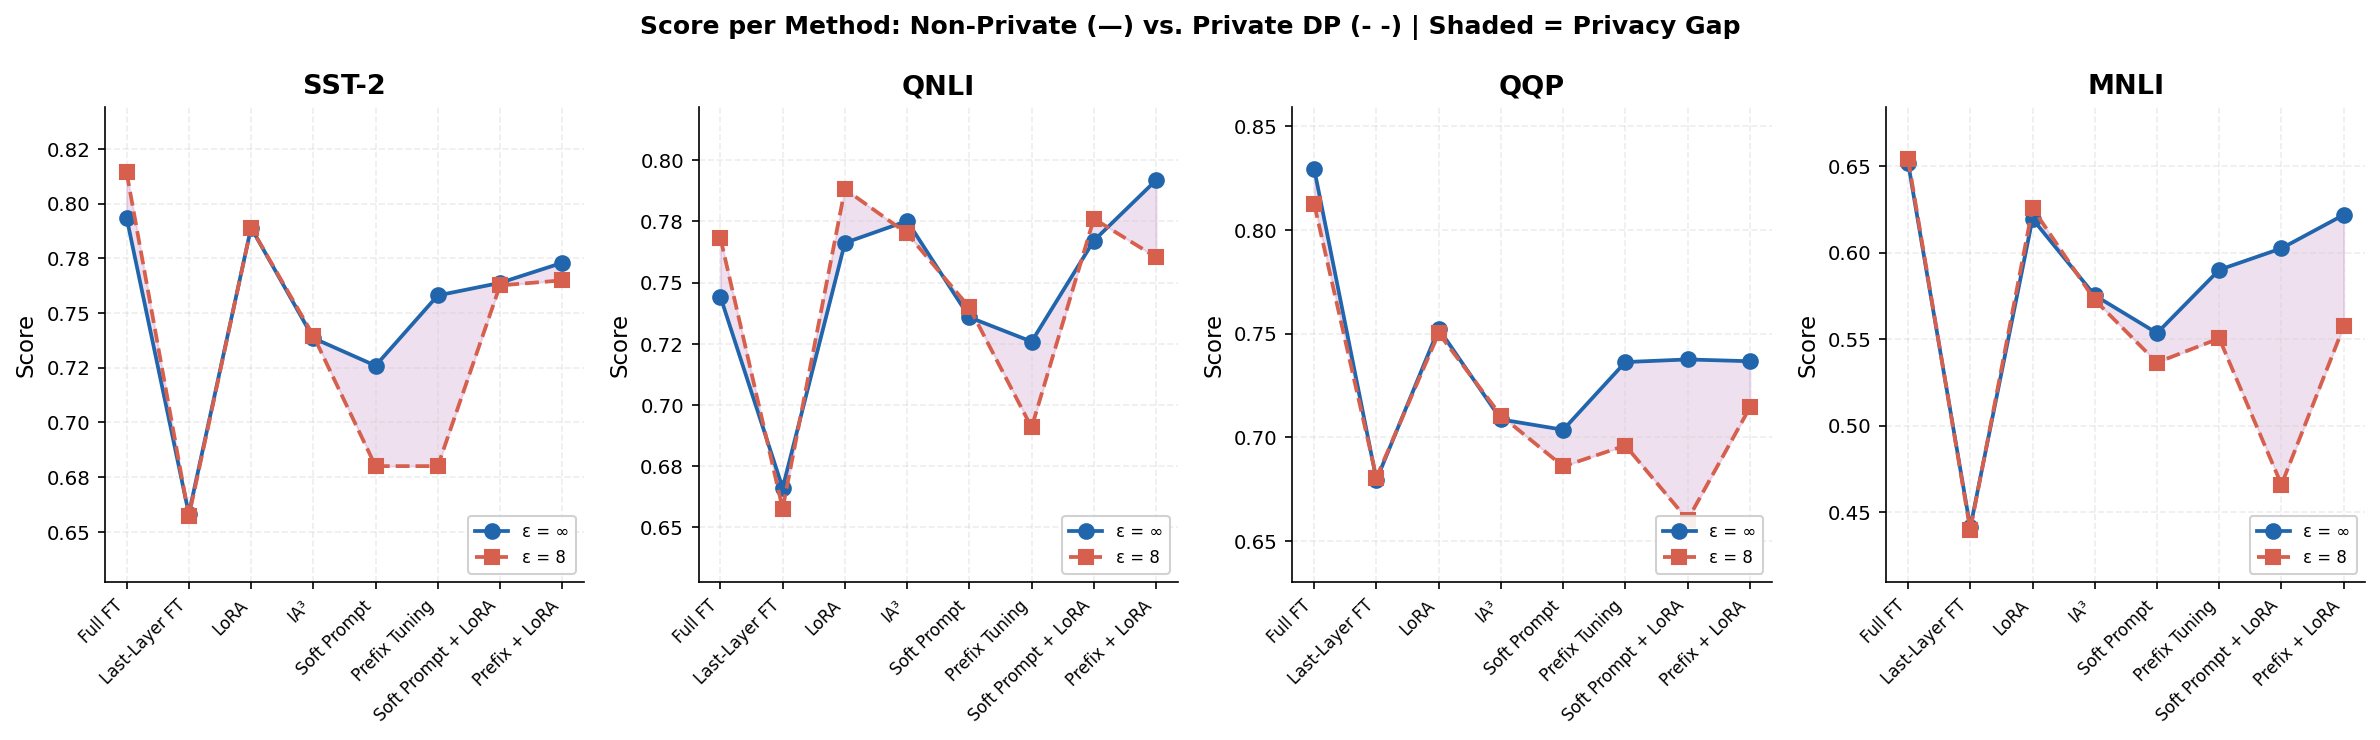

Saved → plots/fig5_privacy_gap_lines.png / .pdf


In [6]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5), sharey=False)
xlabels = [METHOD_LABELS[m] for m in METHOD_ORDER]
x = np.arange(len(METHOD_ORDER))

for ax, dataset in zip(axes, DATASET_ORDER):
    scores_np = (
        df_np[df_np["Dataset"] == dataset]
        .set_index("Method")["Score"].reindex(METHOD_ORDER).values
    )
    scores_dp = (
        df_dp[df_dp["Dataset"] == dataset]
        .set_index("Method")["Score"].reindex(METHOD_ORDER).values
    )

    ax.plot(x, scores_np, color=C_NPRIV, marker="o", ms=7, lw=1.8,
            label="ε = ∞", zorder=4)
    ax.plot(x, scores_dp, color=C_PRIV,  marker="s", ms=7, lw=1.8,
            linestyle="--", label="ε = 8", zorder=4)

    # Fill between to visualise the gap
    ax.fill_between(x, scores_np, scores_dp, alpha=0.12, color="purple")

    ax.set_title(DATASET_LABELS[dataset], fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, rotation=45, ha="right", fontsize=8)
    ax.set_ylabel("Score")
    all_scores = np.concatenate([scores_np, scores_dp])
    margin = 0.03
    ax.set_ylim(np.nanmin(all_scores) - margin, np.nanmax(all_scores) + margin)
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))
    ax.legend(loc="lower right", fontsize=8)

fig.suptitle(
    "Score per Method: Non-Private (—) vs. Private DP (- -) | Shaded = Privacy Gap",
    fontweight="bold", fontsize=12
)
plt.tight_layout()
plt.savefig("plots/fig5_privacy_gap_lines.png")
plt.savefig("plots/fig5_privacy_gap_lines.pdf")
plt.show()
print("Saved → plots/fig5_privacy_gap_lines.png / .pdf")